In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Create worker agents

#### Research agent

In [2]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("who is mayor of NYC?")

print(web_search_results["results"][0]["content"])

Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. In Albany, Eric built winning coalitions to advance New York City’s values and goals, helping to push through measures to protect tenants and workers, combat gun violence, end the NYPD’s abuses of stop and frisk, and advance human rights — including marriage equality. NYC is a trademark and service mark of the City of New York.


In [3]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
   model="openai:gpt-4.1",
   tools=[web_search],
   prompt=(
      "You are a research agent.\n\n"
      "INSTRUCTIONS:\n"
      "- Assist ONLY with research-related tasks, DO NOT do any math\n"
      "- After you're done with your tasks, respond to the supervisor directly\n"
      "- Respond ONLY with the results of your work, do NOT include ANY other text."
   ),
   name="researh_agent"
)

In [5]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
   pretty_message = message.pretty_repr(html=True)
   if not indent:
      print(pretty_message)
      return

   indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
   print(indented)


def pretty_print_messages(update, last_message=False):
   is_subgraph = False
   if isinstance(update, tuple):
      ns, update = update
      # skip parent graph updates in the printouts
      if len(ns) == 0:
         return

      graph_id = ns[-1].split(":")[0]
      print(f"Update from subgraph {graph_id}:")
      print("\n")
      is_subgraph = True

   for node_name, node_update in update.items():
      update_label = f"Update from node {node_name}:"
      if is_subgraph:
         update_label = "\t" + update_label

      print(update_label)
      print("\n")

      messages = convert_to_messages(node_update["messages"])
      if last_message:
         messages = messages[-1:]

      for m in messages:
         pretty_print_message(m, indent=is_subgraph)
      print("\n")

In [6]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: researh_agent
Tool Calls:
  tavily_search (call_eu7cmqKkmUQs38BaXS0xfgTO)
 Call ID: call_eu7cmqKkmUQs38BaXS0xfgTO
  Args:
    query: current mayor of New York City


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "current mayor of New York City", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nyc.gov/office-of-the-mayor/bio.page", "title": "Office of the Mayor | Mayor's Bio | City of New York - NYC.gov", "content": "Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City", "score": 0.82048416, "raw_content": null}, {"url": "https://en.wikipedia.org/wiki/Eric_Adams", "title": "Eric Adams - Wikipedia", "content": "Eric Leroy Adams (born Septem

#### Math agent

In [7]:
def add(a: float, b: float):
   """Add two numbers."""
   return a + b


def multiply(a: float, b: float):
   """Multiply two numbers."""
   return a * b


def divide(a: float, b: float):
   """Divide two numbers."""
   return a / b


math_agent = create_react_agent(
   model="openai:gpt-4.1",
   tools=[add, multiply, divide],
   prompt=(
      "You are a math agent.\n\n"
      "INSTRUCTIONS:\n"
      "- Assist ONLY with math-related tasks\n"
      "- After you're done with your tasks, respond to the supervisor directly\n"
      "- Respond ONLY with the results of your work, do NOT include ANY other text."
   ),
   name="math_agent",
)

In [8]:
for chunk in math_agent.stream(
   {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
   pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_eeQCEZMZuCsCESrU8ZmW1rsm)
 Call ID: call_eeQCEZMZuCsCESrU8ZmW1rsm
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_ETLgINGghANaDysXet21cesJ)
 Call ID: call_ETLgINGghANaDysXet21cesJ
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56




### Create supervisor with langgraph-supervisor

In [13]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
   model = init_chat_model(model="openai:gpt-4.1"),
   agents = [research_agent, math_agent],
   prompt=(
      "You are a supervisor managing two agents:\n"
      "- a research agent. Assign research-related tasks to this agent\n"
      "- a math agent. Assign math-related tasks to this agent\n"
      "Assign work to one agent at a time, do not call agents in parallel.\n"
      "Do not do any work yourself."
   ),
   add_handoff_back_messages = True,
   output_mode = "full_history"
).compile()

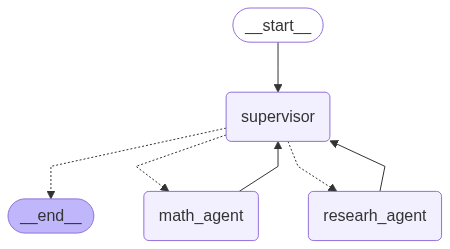

In [14]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [15]:
for chunk in supervisor.stream(
   {
      "messages": [
         {
            "role": "user",
            "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
         }
      ]
   },
):
   pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_researh_agent

Successfully transferred to researh_agent


Update from node researh_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor




Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

In 2024, the US GDP was about $29.18 trillion. New York state's GDP was reported as either $1.8 trillion or $2.297 trillion, depending on the source.

- If NY's GDP was $1.8 trillion, it comprised approximately 6.17% of US GDP.
- If NY's GDP was $2.297 trillion, it comprised approximately 7.87% of US GDP. 

Let me know if you want the sources or further breakdown.




#### Create supervisor from scratch

#### Set up agent communication

In [19]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
   name = f"transfer_to_{agent_name}"
   description = description or f"Ask {agent_name} for help."
   
   @tool(name, description=description)
   def handoff_tool(
      state: Annotated[MessagesState, InjectedState],
      tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
      tool_message = {
         "role": "tool",
         "content": f"Successfully transferred to {agent_name}",
         "name": name,
         "tool_call_id": tool_call_id,
      }
      return Command(
         goto=agent_name,  
         update={**state, "messages": state["messages"] + [tool_message]},  
         graph=Command.PARENT,  
      )

In [20]:
# Handoffs
assign_to_research_agent = create_handoff_tool(
   agent_name="research_agent",
   description="Assign task to a researcher agent.",
)

assign_to_math_agent = create_handoff_tool(
   agent_name="math_agent",
   description="Assign task to a math agent.",
)

#### Create supervisor agent

In [25]:
supervisor_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

AttributeError: 'function' object has no attribute 'name'

In [24]:
math_agent = create_react_agent(
   model="openai:gpt-4.1",
   tools=[add, multiply, divide],
   prompt=(
      "You are a math agent.\n\n"
      "INSTRUCTIONS:\n"
      "- Assist ONLY with math-related tasks\n"
      "- After you're done with your tasks, respond to the supervisor directly\n"
      "- Respond ONLY with the results of your work, do NOT include ANY other text."
   ),
   name="math_agent",
)